# Introduction

Find small single text files for **Language Modeling** experiements here ⬇️

https://www.kaggle.com/datasets/sovitrath/text-generation-language-modeling

In [1]:
import torch
import os
import numpy as np
import string
import re
import glob
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import math
import tiktoken

from tqdm.auto import tqdm
from utils.text_gen import get_batch, train_step, val_step, NLPDataset
from collections import Counter
from torch.utils.data import DataLoader, Dataset, Subset
from torch.optim.lr_scheduler import StepLR

In [2]:
# Set seed.
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [3]:
!nvidia-smi

Fri Dec  1 22:29:16 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3080        Off | 00000000:01:00.0  On |                  N/A |
|  0%   37C    P8              15W / 370W |    611MiB / 10240MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
CHECKPOINT_DIR = 'outputs/text_gen_simple_dec_jungle_book' 
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

In [5]:
dataset_dir = os.path.join('../../input', 'the_jungle_book')
train_file = os.listdir(dataset_dir)
print(train_file)

['text.txt']


## Prepare the Dataset
Let's find the longest review in the entire training set. As this will also contain the <br> tags, we will take the average of that.

We will pad the smaller sentences to this average length and truncate the longer sentences to the average length.

In [6]:
def find_longest_length(text_file_paths):
    """
    Find the longest review length in the entire training set. 

    :param text_file_paths: List, containing all the text file paths.

    Returns:
        max_len: Longest review length.
    """
    max_length = 0
    for path in text_file_paths:
        with open(path, 'r') as f:
            text = f.read()
            corpus = [
                word for word in text.split()
            ]
        if len(corpus) > max_length:
            max_length = len(corpus)
    return max_length


file_paths = []
file_paths.extend(glob.glob(os.path.join(
    dataset_dir, '*.txt'
)))
longest_sentence_length = find_longest_length(file_paths)
print(f"Total words (possibly, without tokenization): {longest_sentence_length} words")

Total words (possibly, without tokenization): 50733 words


In [7]:
# Number of words to generate in a sentence.
SEQUENCE_LENGTH = 256
NUM_WORDS = 50257  # Vocabulary size.

# Batch size.
BATCH_SIZE = 32
VALID_SPLIT = 0.1
MAX_ITERS = 10000

### Helper Functions 

A few helper functions to prepare the dataset.

In [8]:
def find_word_frequency(
    text_file_paths, num_files, most_common=None
):
    """
    Create a list of tuples of the following format,
    [('ho', 2), ('hello', 1), ("let's", 1), ('go', 1)]
    where the number represents the frequency of occurance of 
    the word in the entire dataset.

    :param text_file_paths: List, containing all the text file paths.
    :param most_common: Return these many top words from the dataset.
        If `most_common` is None, return all. If `most_common` is 3,
        returns the top 3 tuple pairs in the list.

    Returns:
        sorted_words: A list of tuple containing each word and it's
        frequency of the format ('ho', 2), ('hello', 1), ...]
    """
    # Add all the words in the entire dataset to `corpus` list.
    corpus = []
    for i, path in enumerate(text_file_paths):
        if i+1 == num_files:
            break
        with open(path, 'r') as f:
            text = f.read()
            # Remove <br> tags.
            text = re.sub('<[^>]+>+', '', text)
            corpus.extend([
                word for word in text.split()
            ])
    count_words = Counter(corpus)
    # Create a dictionary with the most common word in the corpus 
    # at the beginning.
    # `word_frequency` will be like 
    word_frequency = count_words.most_common(n=most_common) # Returns all as n is `None`.
    return word_frequency

In [9]:
def word2int(input_words, num_words):
    """
    Create a dictionary of word to integer mapping for each unique word.

    :param input_words: A list of tuples containing the words and 
        theiry frequency. Should be of the following format,
        [('ho', 2), ('hello', 1), ("let's", 1), ('go', 1)]
    :param num_words: Number of words to use from the `input_words` list 
        to create the mapping. If -1, use all words in the dataset.

    Returns:
        int_mapping: A dictionary of word and a integer mapping as 
            key-value pair. Example, {'Hello,': 1, 'the': 2, 'let': 3}
    """

    if num_words > -1:
        int_mapping = {
            w:i+1 for i, (w, c) in enumerate(input_words) \
                if i <= num_words - 1 # -1 to avoid getting (num_words + 1) integer mapping.
        }
    else:
        int_mapping = {w:i+1 for i, (w, c) in enumerate(input_words)}
    return int_mapping

### Tiktoken

In [10]:
enc = tiktoken.encoding_for_model("gpt2")

## Prepare PyTorch Datasets and Data Loaders

In [11]:
file_paths = os.path.join(dataset_dir, train_file[0])

In [12]:
dataset_inst = NLPDataset(file_paths, enc)
dataset = dataset_inst.get_data()

In [13]:
print(f"Total tokens: {dataset.shape}")
print(f"Number of unique tokens: {len(np.unique(dataset))}")
# print(f"Number of chosen words to act as vocabulary (tokens): {len(int_mapping)}")

Total tokens: torch.Size([78995])
Number of unique tokens: 6042


In [14]:
dataset_size = len(dataset)
# Calculate the validation dataset size.
valid_size = int(VALID_SPLIT*dataset_size)
# Radomize the data indices.
indices = torch.randperm(len(dataset)).tolist()
# Training and validation sets.
dataset_train = dataset[:-valid_size]
dataset_valid = dataset[-valid_size:]

# dataset_valid = NLPClassificationDataset()
print(f"Number of training samples: {len(dataset_train)}")
print(f"Number of validation samples: {len(dataset_valid)}")

Number of training samples: 71096
Number of validation samples: 7899


In [15]:
print(dataset_train.size(0))
print(dataset_valid.size(0))

71096
7899


In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Model

In [17]:
def generate_square_subsequent_mask(sz):
    """
    Generate a square mask for the sequence. The masked positions are filled with float('-inf').
    Unmasked positions are filled with float(0.0).
    """
    mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

In [18]:
class PositionalEncoding(nn.Module):
    def __init__(self, max_len, d_model, dropout=0.1):
        """
        :param max_len: Input length sequence.
        :param d_model: Embedding dimension.
        :param dropout: Dropout value (default=0.1)
        """
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Inputs of forward function
        :param x: the sequence fed to the positional encoder model (required).
        Shape:
            x: [sequence length, batch size, embed dim]
            output: [sequence length, batch size, embed dim]
        """

        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

In [19]:
class TextGen(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_layers, num_heads):
        super(TextGen, self).__init__()
        self.pos_encoder = PositionalEncoding(max_len=SEQUENCE_LENGTH, d_model=embed_dim)
        self.emb = nn.Embedding(vocab_size, embed_dim)
        self.decoder_layer = nn.TransformerDecoderLayer(
            d_model=embed_dim, 
            nhead=num_heads, 
            batch_first=True
        )
        self.decoder = nn.TransformerDecoder(
            decoder_layer=self.decoder_layer,
            num_layers=num_layers,
        )
        self.linear = nn.Linear(embed_dim, vocab_size)
        self.dropout = nn.Dropout(0.2)
        
    # Positional encoding is required. Else the model does not learn.
    def forward(self, x):
        emb = self.emb(x)
        
        # Generate input sequence mask with shape (SEQUENCE_LENGTH, SEQUENCE_LENGTH)
        input_mask = generate_square_subsequent_mask(x.size(1)).to(x.device)
        
        x = self.pos_encoder(emb)
        x = self.decoder(x, memory=x, tgt_mask=input_mask, memory_mask=input_mask)
        x = self.dropout(x)
        out = self.linear(x)
        return out

In [20]:
model = TextGen(
    vocab_size=NUM_WORDS, 
    embed_dim=100,
    num_layers=1, 
    num_heads=1,
)

In [21]:
_ = model.to(device)

## Training

In [22]:
print(model)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(
    model.parameters(), 
    lr=0.0001,
)

# StepLR every specific number of epochs.
scheduler = StepLR(
    optimizer, 
    step_size=5, 
    gamma=0.5,
    verbose=True
)

# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.\n")

TextGen(
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (emb): Embedding(50257, 100)
  (decoder_layer): TransformerDecoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=100, out_features=100, bias=True)
    )
    (multihead_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=100, out_features=100, bias=True)
    )
    (linear1): Linear(in_features=100, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=100, bias=True)
    (norm1): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
    (norm3): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
    (dropout3): Dropout(p=0.1, inplace=False)
  )
  (decoder): Transfor

In [23]:
# Lists to keep track of losses and accuracies.
train_loss, valid_loss = [], []
least_loss = float('inf')
# Start the training.
for iteration in range(MAX_ITERS):
    train_step_loss = train_step(
        model, 
        dataset_train, 
        optimizer, 
        criterion,
        SEQUENCE_LENGTH,
        NUM_WORDS,
        BATCH_SIZE,
        device
    )
    valid_step_loss = val_step(
        model, 
        dataset_valid,  
        criterion,
        SEQUENCE_LENGTH,
        NUM_WORDS,
        BATCH_SIZE,
        device
    )
    train_loss.append(train_step_loss.cpu().detach().numpy())
    valid_loss.append(valid_step_loss.cpu().detach().numpy())
    if iteration % 250 == 0:
        print(f"[INFO]: Iteration {iteration+1} of {MAX_ITERS}")
        print(f"Training loss: {train_step_loss}")
        print(f"Validation loss: {valid_step_loss}")
        print('-'*50)
        # Save model.
        if valid_step_loss < least_loss:
            print(f"Saving best model till now... LEAST LOSS {valid_step_loss:.3f}")
            least_loss = valid_step_loss
            torch.save(
                model, os.path.join(CHECKPOINT_DIR, 'model.pth')
            )
    #     if epoch + 1 <= 32:
#         scheduler.step()
torch.save(
    model, os.path.join(CHECKPOINT_DIR, 'final_model.pth')
)

[INFO]: Iteration 1 of 10000
Training loss: 11.030731201171875
Validation loss: 10.93616771697998
--------------------------------------------------
Saving best model till now... LEAST LOSS 10.936
[INFO]: Iteration 251 of 10000
Training loss: 6.989803314208984
Validation loss: 6.909458160400391
--------------------------------------------------
Saving best model till now... LEAST LOSS 6.909
[INFO]: Iteration 501 of 10000
Training loss: 6.133241653442383
Validation loss: 5.954448699951172
--------------------------------------------------
Saving best model till now... LEAST LOSS 5.954
[INFO]: Iteration 751 of 10000
Training loss: 5.583615779876709
Validation loss: 5.62697696685791
--------------------------------------------------
Saving best model till now... LEAST LOSS 5.627
[INFO]: Iteration 1001 of 10000
Training loss: 5.2772908210754395
Validation loss: 5.326459884643555
--------------------------------------------------
Saving best model till now... LEAST LOSS 5.326
[INFO]: Iterat

In [24]:
def save_plots(train_loss, valid_loss):
    """
    Function to save the loss and accuracy plots to disk.
    """
    plt.show()
    # Loss plots.
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='blue', linestyle='-', 
        label='train loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='-', 
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
#     plt.savefig(f"../outputs/loss.png")
    plt.show()

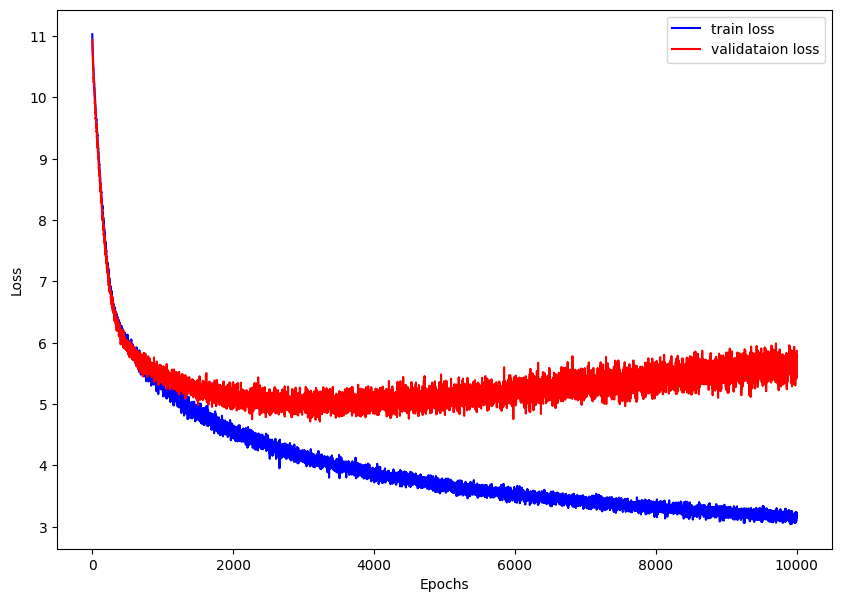

In [25]:
save_plots(train_loss, valid_loss)

## Test Model

In [26]:
trained_model = torch.load(
    os.path.join(CHECKPOINT_DIR, 'model.pth')
)

In [27]:
# test_loss = validate(
#     trained_model, 
#     dataset_test,  
#     criterion, 
#     device
# )

# print(f"Test loss: {test_loss}")

## Text Generation

In [28]:
def return_int_vector(enc, text):
        """
        Assign an integer to each word and return the integers in a list.
        """
        return enc.encode(text)

In [29]:
enc = tiktoken.encoding_for_model("gpt2")

In [30]:
def sample_next(predictions, temperature=1.0):
    """
    Implement variable-temperature sampling from a probability
    distribution.
    """
    predictions = predictions[:, -1, :] / temperature
    probabilities = F.softmax(predictions, dim=-1).cpu()
    next_token = torch.multinomial(probabilities, num_samples=1)
    return int(next_token.cpu())

def text_generator(sentence, generate_length):
    trained_model.eval()
    temperatures = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0] 
    for temperature in temperatures:
        sample = sentence
        print(f"GENERATED SENTENCE WITH TEMPERATURE {temperature}")
        for i in range(generate_length):
            # print(f"Sample: {sample}")
            int_vector = return_int_vector(enc, sample)
            if len(int_vector) >= SEQUENCE_LENGTH - 1:
                break
            input_tensor = torch.tensor(int_vector, dtype=torch.long).to(device)  # Changed dtype to torch.long
            input_tensor = input_tensor.unsqueeze(0)
            with torch.no_grad():
                predictions = trained_model(input_tensor)
            next_token = sample_next(predictions, temperature)  # Pass the temperature to the sample function
            sample += enc.decode([next_token])
        print(sample)
        print('\n')

In [31]:
sentences = [
    "It was seven o’clock of a very warm evening"
]

In [32]:
generate_length = 128

In [33]:
for sentence in sentences:
    print(f"PROMPT: {sentence}")
    text_generator(sentence, generate_length)
    print('\n############\n')

PROMPT: It was seven o’clock of a very warm evening
GENERATED SENTENCE WITH TEMPERATURE 0.1
It was seven o’clock of a very warm evening.

                                                                                                                             


GENERATED SENTENCE WITH TEMPERATURE 0.2
It was seven o’clock of a very warm evening.

                                                                                                                             


GENERATED SENTENCE WITH TEMPERATURE 0.3
It was seven o’clock of a very warm evening
and he could not know that he would have
the Pack, andUV to the
theeo!�.

                                                                                                     


GENERATED SENTENCE WITH TEMPERATURE 0.4
It was seven o’clock of a very warm evening.

                                                                           prohibits I
                                                


GENERATED SENTENCE WITH TEMPERATUR